In [1]:
# -*- coding: utf-8 -*-
import sys
import pandas as pd
#from bs4 import BeautifulSoup
import numpy as np
import requests
import json
from geopy.geocoders import Nominatim
import folium  # map rendering module
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

coding = sys.stdout.encoding

In [9]:
spcities_df = pd.read_csv('0_saopaulo_cities.csv', index_col=0)
total_cities = spcities_df.shape[0]
print("Shape of spcities_df: ", spcities_df.shape)
spcities_df.head()

Shape of spcities_df:  (643, 6)


,Mesoregion,Microregion,City,Population,Longitude,Latitude
0,São José do Rio Preto,Jales,Aparecida d'Oeste,4196,-50.880871,-20.449811
1,São José do Rio Preto,Jales,Aspásia,1822,-50.728046,-20.160028
2,São José do Rio Preto,Jales,Dirce Reis,1793,-50.606276,-20.466407
3,São José do Rio Preto,Jales,Dolcinópolis,2115,-50.513261,-20.123074
4,São José do Rio Preto,Jales,Jales,49107,-50.549244,-20.267177


In [40]:
# Collecting state of São Paulo coordinates
geolocator = Nominatim(user_agent='it_is_me')
saopaulo = geolocator.geocode('São Paulo, Brazil')
latitude, longitude = (saopaulo.latitude+1, saopaulo.longitude-1)

# Create map of São Paulo using latitude and longitude values
map_sp = folium.Map(location=[latitude, longitude], zoom_start=7)

# add markers to map
max_population = spcities_df['Population'].max()
for lat, lng, population, city in zip(spcities_df['Latitude'], spcities_df['Longitude'], spcities_df['Population'], spcities_df['City']):
    label = '{}, {}'.format(city, population)
    label = folium.Popup(label, parse_html=True, max_width=100)
    if(city != 'São Paulo'):
        rad = 6*(population/1370000)
    else:
        rad = 7    
    folium.CircleMarker(
        [lat, lng],
        radius=rad,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sp)  
    
map_sp

In [13]:
saopaulo_venues = pd.read_csv('1_saopaulo_venues.csv')
saopaulo_venues.head(3)

,Unnamed: 0,City,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Aparecida d'Oeste,-20.449811,-50.880871,Farmácia do Pedro,-20.451159,-50.881847,Pharmacy
1,1,Aparecida d'Oeste,-20.449811,-50.880871,Bar do Fabião,-20.450060,-50.886469,African Restaurant
2,2,Dirce Reis,-20.466407,-50.606276,Padaria Doce Pao,-20.464830,-50.606962,Bakery


In [2]:
# sp cities with all venues one-hot-encoded
saopaulo_onehot = pd.read_csv('2_saopaulo_onehot.csv')
print("saopaulo_onehot.shape: ", saopaulo_onehot.shape)
saopaulo_onehot.head(3)

saopaulo_onehot.shape:  (14757, 393)


,Unnamed: 0,Zoo Exhibit,ATM,Acai House,Accessories Store,Adult Boutique,African Restaurant,Airport,Airport Lounge,Airport Terminal,...,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# sp cities with similar venues merged
spcities_onehot = pd.read_csv('3_spcities_onehot.csv', index_col=0)

print('spcities_onehot.shape: ', spcities_onehot.shape)
spcities_onehot.head(3)

spcities_onehot.shape:  (14757, 229)


,City,ATM,Acai House,Accessories Store,Adult Boutique,African Restaurant,Airport,American Restaurant,Antique Shop,Aquarium,...,Volleyball Court,Warehouse Store,Watch Shop,Waterfall,Waterfront,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Aparecida d'Oeste,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Aparecida d'Oeste,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Dirce Reis,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Eliminate categories with too few or too much occurences.
cols = list(spcities_onehot.columns)
cols.remove('City')
categories_counter = spcities_onehot[cols].sum()
categories_counter = categories_counter[categories_counter<500]  # too much means most of cities have, so it does not differenciate cities
categories_counter = categories_counter[categories_counter>150]  # too few means too few cities have it, so it also does not differenciate them
relevant_categories = list(categories_counter.index)

print('Now, there are {} relevant categories, which are: '.format(len(relevant_categories)))
print(relevant_categories)

Now, there are 15 relevant categories, which are: 
['BBQ Joint', 'Bed & Breakfast', 'Burger Joint', 'Café', 'Coffee Shop', 'Convenience Store', 'Dessert Shop', 'Fast Food Restaurant', 'Grocery Store', 'Italian Restaurant', 'Japanese Restaurant', 'Market', 'Park', 'Pharmacy', 'Plaza']


In [5]:
spcities = spcities_onehot[['City'] + relevant_categories]
spcities.to_csv('4_spcities.csv')
print("spcities.shape: ", spcities.shape)
spcities.head(3)

spcities.shape:  (14757, 16)


,City,BBQ Joint,Bed & Breakfast,Burger Joint,Café,Coffee Shop,Convenience Store,Dessert Shop,Fast Food Restaurant,Grocery Store,Italian Restaurant,Japanese Restaurant,Market,Park,Pharmacy,Plaza
0,Aparecida d'Oeste,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,Aparecida d'Oeste,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Dirce Reis,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
# Calculating normalized frequency of occurence of each venue on each city = cities' profiles
spcities_grouped = spcities.groupby('City').mean().reset_index()
print('spcities_grouped.shape: ', spcities_grouped.shape)
spcities_grouped.head(3)

spcities_grouped.shape:  (623, 16)


,City,BBQ Joint,Bed & Breakfast,Burger Joint,Café,Coffee Shop,Convenience Store,Dessert Shop,Fast Food Restaurant,Grocery Store,Italian Restaurant,Japanese Restaurant,Market,Park,Pharmacy,Plaza
0,Adamantina,0.02,0.0,0.04,0.02,0.0,0.020000,0.0,0.0,0.020000,0.0,0.04,0.040000,0.040000,0.02,0.0
1,Adolfo,0.00,0.0,0.00,0.00,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00,0.000000,0.000000,1.00,0.0
2,Aguaí,0.00,0.0,0.00,0.00,0.0,0.052632,0.0,0.0,0.052632,0.0,0.00,0.105263,0.105263,0.00,0.0


In [7]:
# select São Paulo capital index
saopaulo_capital = spcities_grouped[spcities_grouped.City=='São Paulo'].index[0]

# delete capital's row, because it is an outlier. It is too big compared to all other cities!
spcities_grouped.drop(saopaulo_capital, axis=0, inplace=True)
spcities_grouped.shape

(622, 16)

In [10]:
# Merge cities' profile to population info
spcities_profile = spcities_grouped.merge(spcities_df[['City','Population']], left_on='City', right_on='City')

# Normalize Population data
min_population = spcities_profile['Population'].min()
max_population = spcities_profile['Population'].max()
print('max_population: {}; min_population: {}'.format(min_population, max_population))
spcities_profile['Population'] = (spcities_profile['Population'] - min_population)/(max_population - min_population)
cols = list(spcities_profile.columns)
cols.remove('City')
cols.remove('Population')
cols = ['City', 'Population'] + cols
spcities_profile = spcities_profile[cols]

spcities_profile.to_csv('5_spcities_profile.csv')
print("spcities_profile.shape = ", spcities_profile.shape)
spcities_profile.head(3)

max_population: 1165; min_population: 1379182
spcities_profile.shape =  (622, 17)


,City,Population,BBQ Joint,Bed & Breakfast,Burger Joint,Café,Coffee Shop,Convenience Store,Dessert Shop,Fast Food Restaurant,Grocery Store,Italian Restaurant,Japanese Restaurant,Market,Park,Pharmacy,Plaza
0,Adamantina,0.024603,0.02,0.0,0.04,0.02,0.0,0.020000,0.0,0.0,0.020000,0.0,0.04,0.040000,0.040000,0.02,0.0
1,Adolfo,0.001739,0.00,0.0,0.00,0.00,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00,0.000000,0.000000,1.00,0.0
2,Aguaí,0.025500,0.00,0.0,0.00,0.00,0.0,0.052632,0.0,0.0,0.052632,0.0,0.00,0.105263,0.105263,0.00,0.0


In [34]:
# Calculate the rate of each venue category per habitant
venues_vs_population = spcities_profile.copy()
for i in np.arange(3, venues_vs_population.shape[1]):
    venues_vs_population.iloc[:, i] = venues_vs_population.Population.div(venues_vs_population.iloc[:, i], axis=0)

venues_vs_population.head()

,City,Population,BBQ Joint,Bed & Breakfast,Burger Joint,Café,Coffee Shop,Convenience Store,Dessert Shop,Fast Food Restaurant,Grocery Store,Italian Restaurant,Japanese Restaurant,Market,Park,Pharmacy,Plaza
0,Adamantina,0.024603,0.02,inf,0.615069,1.230137,inf,1.230137,inf,inf,1.230137,inf,0.615069,0.615069,0.615069,1.230137,inf
1,Adolfo,0.001739,0.00,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,0.001739,inf
2,Aguaí,0.025500,0.00,inf,inf,inf,inf,0.484508,inf,inf,0.484508,inf,inf,0.242254,0.242254,inf,inf
3,Agudos,0.026160,0.00,inf,inf,0.627841,inf,inf,inf,inf,0.627841,inf,inf,inf,inf,inf,0.627841
4,Alambari,0.003527,0.00,0.014107,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


In [35]:
# replace infinite and nan values wwith double of max value and zero, respectively
venues_vs_population.replace([np.inf, -np.inf], 200, inplace=True)
venues_vs_population.replace([np.nan, -np.nan], 0, inplace=True)

# normalize values according to column
min_profile = venues_vs_population.iloc[:, 3:].min()
max_profile = venues_vs_population.iloc[:, 3:].max()
venues_vs_population.iloc[:, 3:] = (venues_vs_population.iloc[:, 3:] - min_profile)/(max_profile - min_profile)
venues_vs_population.head()

,City,Population,BBQ Joint,Bed & Breakfast,Burger Joint,Café,Coffee Shop,Convenience Store,Dessert Shop,Fast Food Restaurant,Grocery Store,Italian Restaurant,Japanese Restaurant,Market,Park,Pharmacy,Plaza
0,Adamantina,0.024603,0.02,1.000000,0.003075,0.006151,1.0,0.006151,1.0,1.0,0.006151,1.0,0.003075,0.003075,0.003075,0.006151,1.000000
1,Adolfo,0.001739,0.00,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.000000,1.000000,0.000009,1.000000
2,Aguaí,0.025500,0.00,1.000000,1.000000,1.000000,1.0,0.002423,1.0,1.0,0.002423,1.0,1.000000,0.001211,0.001211,1.000000,1.000000
3,Agudos,0.026160,0.00,1.000000,1.000000,0.003139,1.0,1.000000,1.0,1.0,0.003139,1.0,1.000000,1.000000,1.000000,1.000000,0.003139
4,Alambari,0.003527,0.00,0.000071,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


## SP Cities' 10th. Most Common Venues

In [36]:
# Function to sort the first 'num_top_venues' most common venues on a row.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:-1]
    row_categories_sorted = row_categories.sort_values(ascending=True)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10  # considerate the first 10 most common venues.
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cities_venues_sorted = pd.DataFrame(columns=columns)
cities_venues_sorted['City'] = spcities_profile['City']

for ind in np.arange(spcities_profile.shape[0]):
    cities_venues_sorted.iloc[ind, 1:] = return_most_common_venues(spcities_profile.iloc[ind, :], num_top_venues)

print("cities_venues_sorted.shape: ", cities_venues_sorted.shape)
cities_venues_sorted.head(3)

cities_venues_sorted.shape:  (622, 11)


,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adamantina,Bed & Breakfast,Coffee Shop,Dessert Shop,Fast Food Restaurant,Italian Restaurant,BBQ Joint,Café,Convenience Store,Grocery Store,Pharmacy
1,Adolfo,BBQ Joint,Bed & Breakfast,Burger Joint,Café,Coffee Shop,Convenience Store,Dessert Shop,Fast Food Restaurant,Grocery Store,Italian Restaurant
2,Aguaí,BBQ Joint,Bed & Breakfast,Burger Joint,Café,Coffee Shop,Dessert Shop,Fast Food Restaurant,Italian Restaurant,Japanese Restaurant,Pharmacy


## Clustering

In [24]:
# Import K-Means from clustering stage
from sklearn.cluster import KMeans

### Finding best K

In [37]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

results_list = []
# where kcluster is number of clusters
for kclusters in np.arange(3, 9):
    #spcities_clustering = spcities_profile.drop('City', 1)
    spcities_clustering = venues_vs_population.drop('City', 1)

    # run K-Means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(spcities_clustering)

    # check cluster labels generated for each row in the dataframe
    kmeans.labels_[0:10]

    # add clustering labels
    result = cities_venues_sorted[['City']]
    result.insert(0, 'Cluster Labels', kmeans.labels_)

    # copy neighborhoods_df on spcities_merged
    spcities_merged = spcities_df[['City','Latitude','Longitude','Population']]

    # merge toronto neighborhoods dataframe with neighborhoods profile dataframe
    spcities_merged = spcities_merged.merge(result.set_index('City'), left_on='City', right_on='City')

    # list results
    results_list.append(spcities_merged)

    print("kcluster = {}".format(kclusters))
    print("Max cluster: {}".format(spcities_merged[['Cluster Labels']].max()))
    #print("shape of spcities_merged: ", spcities_merged.shape)
    #spcities_merged.head(3) # check first rows

results_list[:5]

kcluster = 3
Max cluster: Cluster Labels    2
dtype: int32
kcluster = 4
Max cluster: Cluster Labels    3
dtype: int32
kcluster = 5
Max cluster: Cluster Labels    4
dtype: int32
kcluster = 6
Max cluster: Cluster Labels    5
dtype: int32
kcluster = 7
Max cluster: Cluster Labels    6
dtype: int32
kcluster = 8
Max cluster: Cluster Labels    7
dtype: int32


[                  City   Latitude  Longitude  Population  Cluster Labels
 0    Aparecida d'Oeste -20.449811 -50.880871        4196               1
 1           Dirce Reis -20.466407 -50.606276        1793               1
 2         Dolcinópolis -20.123074 -50.513261        2115               1
 3                Jales -20.267177 -50.549244       49107               2
 4          Marinópolis -20.440833 -50.822778        2112               1
 ..                 ...        ...        ...         ...             ...
 617            Cubatão -23.885798 -46.424187      130705               2
 618            Guarujá -23.992777 -46.255833      320459               2
 619       Praia Grande -24.005833 -46.402778      325073               2
 620             Santos -23.960833 -46.333889      433311               2
 621        São Vicente -23.960369 -46.384702      365798               2
 
 [622 rows x 5 columns],
                   City   Latitude  Longitude  Population  Cluster Labels
 0    Apare

In [26]:
#venues_vs_population.drop('Cluster Labels', axis=1, inplace=True)

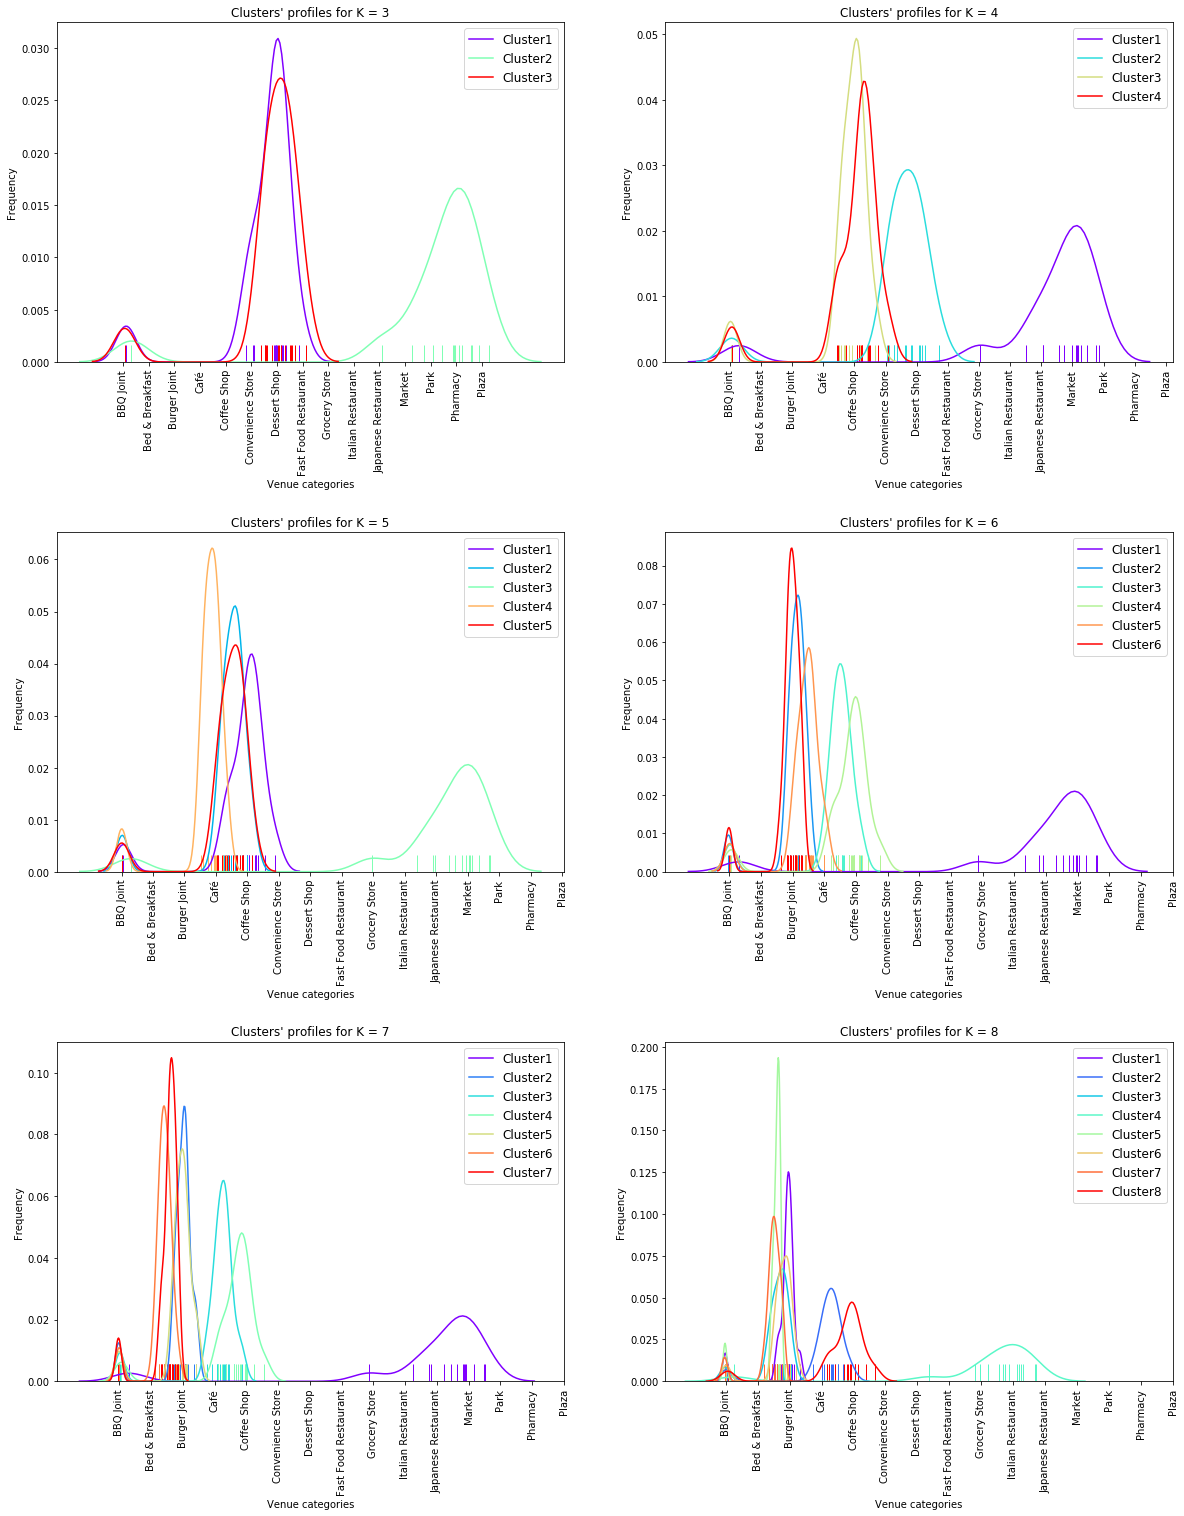

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,25))
plt.subplots_adjust(hspace=0.5)

#venues_vs_population.drop('Cluster Labels', axis=1, inplace=True)
for kclusters in np.arange(3, 9):
    plt.subplot(32*10+(1+kclusters-3))
    spcities_clusters = results_list[kclusters-3]
    kmeans_labels = list(spcities_clusters['Cluster Labels'])

    venues_vs_population.insert(0, 'Cluster Labels', kmeans_labels)

    #plt.figure(figsize=(20,8))
    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    for i in range(kclusters):
        df = venues_vs_population[venues_vs_population['Cluster Labels'] == i]
        df_profile = df.sum()
        
        label = 'Cluster' + str(i+1)
        sns.distplot(df_profile.iloc[3:], rug=True, hist=False, kde=True, label=label, color=rainbow[i])

    categories = list(df_profile.index)[3:]
    ticks = np.arange(len(categories))*19.5 + 1
    #print(categories)
    #print(ticks)

    # Plot formatting
    plt.legend(prop={'size': 12})
    plt.title('Clusters\' profiles for K = {}'.format(kclusters))
    plt.xlabel('Venue categories')
    plt.xticks(ticks=ticks, labels=categories, rotation='vertical')
    plt.ylabel('Frequency')
    
    venues_vs_population.drop('Cluster Labels', axis=1, inplace=True)

In [42]:
# for solution with 4 clusters
kclusters=4
spcities_merged = results_list[1]

# create map
map_clusters = folium.Map(location=[latitude+0.3, longitude-0.8], zoom_start=7.3)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
min_population = spcities_merged['Population'].min()
for lat, lon, poi, cluster, population in zip(spcities_merged['Latitude'], spcities_merged['Longitude'], spcities_merged['City'], spcities_merged['Cluster Labels'], spcities_merged['Population']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    if(poi != 'São Paulo'):
        rad = 4*(population/(1370000-min_population)) + 2.5
    else:
        rad = 10 
    folium.CircleMarker(
        [lat, lon],
        radius=rad,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

### Modeling with best Kclusters found

In [360]:
# set number of clusters
kclusters = 5

spcities_clustering = spcities_profile.drop('City', 1)

# run K-Means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(spcities_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 2, 1, 1, 2, 0, 2, 1, 2, 0])

In [361]:
# add clustering labels
cities_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
#cities_venues_sorted['Cluster Labels'] = kmeans.labels_

# copy neighborhoods_df on spcities_merged
spcities_merged = spcities_df[['City','Latitude','Longitude','Population']]

# merge toronto neighborhoods dataframe with neighborhoods profile dataframe
spcities_merged = spcities_merged.merge(cities_venues_sorted.set_index('City'), left_on='City', right_on='City')

print("shape of spcities_merged: ", spcities_merged.shape)
spcities_merged.head(3) # check first rows

shape of spcities_merged:  (622, 15)


,City,Latitude,Longitude,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aparecida d'Oeste,-20.449811,-50.880871,4196,2,BBQ Joint,Pharmacy,Population,Bed & Breakfast,Burger Joint,Café,Coffee Shop,Convenience Store,Dessert Shop,Fast Food Restaurant
1,Dirce Reis,-20.466407,-50.606276,1793,2,BBQ Joint,Population,Bed & Breakfast,Burger Joint,Café,Coffee Shop,Convenience Store,Dessert Shop,Fast Food Restaurant,Grocery Store
2,Dolcinópolis,-20.123074,-50.513261,2115,2,BBQ Joint,Population,Bed & Breakfast,Burger Joint,Café,Coffee Shop,Convenience Store,Dessert Shop,Fast Food Restaurant,Grocery Store


In [362]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude+0.3, longitude-0.8], zoom_start=7.3)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
min_population = spcities_merged['Population'].min()
for lat, lon, poi, cluster, population in zip(spcities_merged['Latitude'], spcities_merged['Longitude'], spcities_merged['City'], spcities_merged['Cluster Labels'], spcities_merged['Population']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    if(poi != 'São Paulo'):
        rad = 4*(population/(1370000-min_population)) + 2.5
    else:
        rad = 10 
    folium.CircleMarker(
        [lat, lon],
        radius=rad,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters